In [1]:
from dask_cloudprovider.aws import EC2Cluster 
from dask.distributed import Client
import configparser
import os
import contextlib
import re
import dask
from platform import python_version

def get_aws_credentials():
    """Read in your AWS credentials file and convert to environment variables."""
    parser = configparser.RawConfigParser()
    
    parser.read(os.path.expanduser('~/.aws/config'))
    config = parser.items('default')
    
    parser.read(os.path.expanduser('~/.aws/credentials'))
    credentials = parser.items('default')
    
    all_credentials = {key.upper(): value for key, value in [*config, *credentials]}
    with contextlib.suppress(KeyError):
        all_credentials["AWS_REGION"] = all_credentials.pop("REGION")
        
    return all_credentials

# Pass in AWS Credentials + any extra packages you would like to install on cluster via `pip`
env_vars = get_aws_credentials()
env_vars["EXTRA_PIP_PACKAGES"] = "s3fs"

# Select software installed on scheduler + worker instances based on client Python + Dask versions
# versions need to match across client, scheduler, worker -- slight mismatches are OK, though
py_v = '-py' + re.findall(r'\d{1}.\d+', python_version())[0]
dask_docker_tag = f"daskdev/dask:{dask.__version__ + py_v}"
print('Docker Image: ', dask_docker_tag)

# launch a cluster of 5 r5.large instances (10 vCPUs):
# 1 scheduler
# 4 workers (2 threads + 16 GB RAM each)
cluster = EC2Cluster(instance_type='r5.large',
                     n_workers=4,
                     security=False,
                     docker_image=dask_docker_tag,
                     env_vars=env_vars
)

Docker Image:  daskdev/dask:2025.5.1-py3.12
Creating scheduler instance
Created instance i-061d514aa3597bce9 as dask-bbc9b753-scheduler
Waiting for scheduler to run at 54.196.120.34:8786
Scheduler is running
Creating worker instance
Creating worker instance


/opt/anaconda3/lib/python3.12/contextlib.py:144: UserWarning: Creating your cluster is taking a surprisingly long time. This is likely due to pending resources. Hang tight! 
  next(self.gen)


Creating worker instance
Creating worker instance
Created instance i-0248da15334cb9603 as dask-bbc9b753-worker-0113496f
Created instance i-07396cf1e94456619 as dask-bbc9b753-worker-8b403695
Created instance i-0d97f4cbb2815f4d8 as dask-bbc9b753-worker-465b244e
Created instance i-0314b538645ea4ac9 as dask-bbc9b753-worker-d02c0aa7


In [2]:
client = Client(cluster)
client.wait_for_workers(4)

/opt/anaconda3/lib/python3.12/site-packages/distributed/client.py:1582: VersionMismatchWarning: Mismatched versions found

+-------------+----------------+-----------------+---------+
| Package     | Client         | Scheduler       | Workers |
+-------------+----------------+-----------------+---------+
| cloudpickle | 3.0.0          | 3.1.1           | None    |
| lz4         | 4.3.3          | 4.4.4           | None    |
| msgpack     | 1.0.7          | 1.1.0           | None    |
| python      | 3.12.2.final.0 | 3.12.10.final.0 | None    |
| tornado     | 6.4.1          | 6.5             | None    |
+-------------+----------------+-----------------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [3]:
# on scheduler
client.run_on_scheduler(
    lambda: __import__("pip").main(["install",
       "stackstac","rioxarray","pystac-client","pyproj","rasterio","geopandas","xarray","bottleneck","shapely","rtree","fiona","planetary-computer","regionmask"])
)

# on all workers
client.run(lambda: __import__("pip").main(["install",
       "stackstac","rioxarray","pystac-client","pyproj","rasterio","geopandas","xarray","bottleneck","shapely", "rtree","fiona","planetary-computer","regionmask"]))

{'tcp://172.31.33.107:33919': 0,
 'tcp://172.31.38.254:34927': 0,
 'tcp://172.31.42.98:43877': 0,
 'tcp://172.31.44.154:34009': 0}

# Overview: Distributed Data Preparation for Toronto Hex-Spatial Modeling

## Abstract

This project implements a scalable and reproducible pipeline for preparing high-resolution spatial–temporal datasets over the Toronto metropolitan area. Leveraging **Dask distributed computing**, **AWS EC2 clusters**, and **Planetary Computer satellite data**, I extract, clean, and harmonize multi-source data—including crime reports, pedestrian traffic, vegetation indices (NDVI), land surface temperature (LST), and school density—mapped into a unified hexagonal grid over the period 2014–2024.

---

## 1. High-Performance Cluster Configuration

- **Hybrid Local & Cloud Execution**:  
  Development starts on scaling to an `EC2Cluster` on AWS (1 scheduler + 4 `r5.large` workers).
  
- **Environment Synchronization**:  
  Docker images are dynamically version-matched with local Python/Dask versions, avoiding binary incompatibilities.

- **Dependency Broadcast**:  
  Using `client.run_on_scheduler` and `client.run`, all cluster nodes install geospatial, raster, and planetary-computer dependencies (`stackstac`, `rioxarray`, `shapely`, etc.) programmatically.

---

## 2. Distributed Ingestion & Cleaning of Crime Records

- **Lazy CSV Reading with Schema Control**:  
  Crime data is read from S3 with Dask, enforcing nullable types and custom `na_values` for robust parsing.

- **Efficient Cleaning & Filtering**:  
  Months are mapped from names to integers using `.map(...)`, and invalid rows are dropped. Data is filtered to years 2014–2024.

- **Optimized Output**:  
  Cleaned data is written to S3 in Snappy-compressed Parquet format, partitioned by year and month for downstream I/O efficiency.

---

## 3. Spatial Grid Construction & Geospatial Joins

- **Hexagonal Grid Generation**:  
  A 5 km tessellation is generated using NumPy and Shapely, wrapped in a GeoDataFrame, and saved as Parquet with WKT geometries.

- **Parallelized Spatial Join**:  
  Crime points are matched to hexes using Dask futures and partitioned `map_partitions` with STRtrees per worker.

- **Daily Crime Aggregation**:  
  Normalized timestamps are grouped by `(hex_id, day)` and stored as daily crime counts in Parquet format.

---

## 4. Raster Zonal Statistics for NDVI and LST

- **Delayed Month-Level Processing**:  
  Monthly tasks (2014–2024) for NDVI and LST extraction are wrapped in `dask.delayed`, allowing lazy graph construction with >130 nodes.

- **Cloud Masking and Median Composites**:  
  Using StackSTAC, Landsat imagery is cloud-filtered and aggregated into median NDVI and LST values.

- **Zonal Means per Hex**:  
  Each hex polygon is clipped and averaged using `rio.clip(...)`, producing a dense spatial–temporal matrix.

- **Interpolation and Upload**:  
  Missing months are linearly interpolated per hex, then re-partitioned and uploaded to S3.

---

## 5. Ancillary Feature Integration

- **School Density**:  
  School point data is spatially joined to hexagons and aggregated to counts, saved as a Parquet feature layer.

- **Pedestrian Traffic (TMC)**:  
  TMC counts from 2010–2029 are ingested, cleaned, summed, and spatially joined to hexes, then aggregated to daily and monthly counts.

---

## 6. Scalability & Performance Highlights

- **Lazy Evaluation**:  
  Most operations remain deferred until final I/O, enabling Dask's task fusion and global optimizations.

- **Parquet Partition Pruning**:  
  Writing outputs partitioned by `month` or `year/month` enables selective reading in future analyses.

- **Memory–Compute Balance**:  
  `r5.large` instances with 2 threads and 16 GB RAM per worker strike an optimal compute–I/O balance for geospatial workloads.

- **Reproducibility**:  
  All dependencies, AWS credentials, cluster setup, and file locations are fully scripted, ensuring portability across machines or teams.

---

## Summary

This pipeline demonstrates how large-scale parallel computing can transform raw, heterogeneous urban data into structured, hex-level analytical datasets. The resulting outputs are primed for use in spatial econometrics, machine learning, and policy simulation frameworks.

### 1. Distributed Ingestion & Cleaning of Crime Records
- Loads raw crime CSV from S3 with Dask, specifying block size and nullable dtypes.
- Converts month strings to integers via a vectorized .map(...).
- Drops invalid/missing months and filters to your study window (2014–2024).
- Writes cleaned data to S3 in Snappy-compressed Parquet, partitioned by OCC_YEAR and OCC_MONTH—enabling fast, pruned reads later.


In [5]:
import dask.dataframe as dd
import s3fs
import calendar

# S3 setup
s3 = s3fs.S3FileSystem(anon=False)
raw_path = "s3://paul-project-bucket/major-crime-indicators.csv"
s3.put(
    "major-crime-indicators.csv",
    raw_path
)

# Read CSV: year as nullable int, month as string
df = dd.read_csv(
    raw_path,
    storage_options={'anon': False},
    assume_missing=True,
    blocksize="64MB",
    dtype={
        'OCC_YEAR':  'Int64',
        'OCC_MONTH': 'object'
    },
    na_values=['NSA',''],
    keep_default_na=True
)

# Build a mapping from month name → number
month_map = {name: i for i, name in enumerate(calendar.month_name) if name}

# Convert the OCC_MONTH strings to integers
df['OCC_MONTH'] = df['OCC_MONTH'].map(
    month_map,
    meta=('OCC_MONTH', 'Int64')
)

# Drop any rows where the month was invalid (map gave NA)
df = df.dropna(subset=['OCC_MONTH'])

# Filter to the years you want
df = df[(df['OCC_YEAR'] >= 2014) & (df['OCC_YEAR'] <= 2024)]

# Finally write out partitioned Parquet by numeric year & month
dd.to_parquet(
    df,
    "s3://paul-project-bucket/tps/bronze/crime_by_year_month",
    engine="pyarrow",
    write_index=False,
    compression="snappy",
    partition_on=["OCC_YEAR", "OCC_MONTH"],
    storage_options={'anon': False},
    schema="infer"
)

/opt/anaconda3/lib/python3.12/site-packages/dask_expr/_collection.py:301: UserWarning: Dask annotations {'retries': 5} detected. Annotations will be ignored when using query-planning.
  warnings.warn(


### 2. Crime Data Deduplication, Rounding & Final Parquet
- Reads the partitioned Parquet back into Dask.
- Drops any remaining nulls, then deduplicates on all columns except the unique _id.
- Rounds geographic coordinates to 7 decimal places to reduce noise.
- Emits the final “clean” crime table, again partitioned for efficient downstream filtering.

In [6]:
# Read the full partitioned set
ddf = dd.read_parquet(
    "s3://paul-project-bucket/tps/bronze/crime_by_year_month",
    storage_options={'anon': False},
    engine="pyarrow"
)
print(ddf.npartitions)
# drop rows with null, NaN, or missing data
ddf = ddf.dropna()
# Identify all the columns except your unique key
cols = [c for c in ddf.columns if c != "_id"]

# Count total rows by counting a non-null column (here _id)
orig_count = ddf["_id"].count().compute()
print(f"Original rows: {orig_count:,}")

# Drop true duplicates: identical on every col in `cols`, keep the first _id
ddf_clean = ddf.drop_duplicates(subset=cols, keep="first")

# Count rows after dedupe
clean_count = ddf_clean["_id"].count().compute()
print(f"Rows after dedupe: {clean_count:,}")
print(f"Duplicates removed: {orig_count - clean_count:,}")

# Round LONG_WGS84 and LAT_WGS84 to 7 decimal places
ddf['LONG_WGS84'] = ddf['LONG_WGS84'].round(7)
ddf['LAT_WGS84']  = ddf['LAT_WGS84'].round(7)

ddf.to_parquet(
    "s3://paul-project-bucket/tps/cleaned/crime_rounded_coords",
    engine="pyarrow",
    write_index=False,
    compression="snappy",
    partition_on=["OCC_YEAR", "OCC_MONTH"],
    storage_options={'anon': False},
    schema="infer"
)

132
Original rows: 411,996
Rows after dedupe: 381,738
Duplicates removed: 30,258


### 3. City Boundary Dissolution & Hex Grid Construction
- Dissolves individual patrol zones into one MultiPolygon representing the city boundary.
- Builds a 5 km hexagonal tessellation over the bounding box using NumPy loops and Shapely.
- Serializes WKT geometries into Parquet so they can be broadcast efficiently to Dask workers.

In [8]:
import geopandas as gpd

gdf_zones = gpd.read_file("Patrol Zones - 4326.geojson")

# Ensure it’s in a projected CRS for accurate union (e.g. EPSG:26917 UTM zone 17N)
gdf_zones = gdf_zones.to_crs(epsg=26917)

# Dissolve all zones into one MultiPolygon
city_boundary = gdf_zones.dissolve()  # by default merges all rows
city_boundary = city_boundary.to_crs(epsg=4326)

# Save out the result
city_boundary.to_file("Toronto_City_Boundary.geojson", driver="GeoJSON")

In [24]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon

# bbox and cell size
bbox    = (-79.64, 43.58, -79.12, 43.86)
cell_deg = 5000 / 111000

# build polygons
xs = np.arange(bbox[0], bbox[2], cell_deg)
ys = np.arange(bbox[1], bbox[3], cell_deg)
polys = []
for j, y in enumerate(ys):
    for i, x in enumerate(xs):
        x0 = x + (cell_deg/2 if j % 2 else 0)
        r  = cell_deg / np.sqrt(3)
        angles = np.deg2rad(np.arange(0,360,60))
        verts  = [(x0 + r*np.cos(a), y + r*np.sin(a)) for a in angles]
        polys.append(Polygon(verts))

gdf_hex = gpd.GeoDataFrame(
    {"hex_id": np.arange(len(polys))},
    geometry=polys,
    crs="EPSG:4326"
)

In [25]:
import shapely
gdf_hex["geometry_wkt"] = gdf_hex.geometry.apply(lambda geom: geom.wkt)
pdf = gdf_hex[["hex_id","geometry_wkt"]]

In [26]:
print(len(gdf_hex), "hexagons")
print(gdf_hex.head())

84 hexagons
   hex_id                                           geometry  \
0       0  POLYGON ((-79.61399 43.58, -79.627 43.60252, -...   
1       1  POLYGON ((-79.56895 43.58, -79.58195 43.60252,...   
2       2  POLYGON ((-79.5239 43.58, -79.53691 43.60252, ...   
3       3  POLYGON ((-79.47886 43.58, -79.49186 43.60252,...   
4       4  POLYGON ((-79.43381 43.58, -79.44682 43.60252,...   

                                        geometry_wkt  
0  POLYGON ((-79.61399323111759 43.58, -79.626996...  
1  POLYGON ((-79.56894818607255 43.58, -79.581951...  
2  POLYGON ((-79.5239031410275 43.58, -79.5369065...  
3  POLYGON ((-79.47885809598246 43.58, -79.491861...  
4  POLYGON ((-79.43381305093742 43.58, -79.446816...  


In [27]:
import dask.dataframe as dd
ddf_hex = dd.from_pandas(pdf, npartitions=10)

ddf_hex.to_parquet(
  "s3://paul-project-bucket/grid/hex5000.parquet",
  engine="pyarrow",
  write_index=False,
  storage_options={"anon": False}
)

In [ ]:
import dask.dataframe as dd
import pandas as pd
import geopandas as gpd
from shapely import wkt

# Read the Parquet
ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)

# Convert to pandas & parse WKT → geometry
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)

# 1.3 Wrap as GeoDataFrame
gdf_hex = gpd.GeoDataFrame(
    pdf_hex[["hex_id","geometry"]],
    geometry="geometry",
    crs="EPSG:4326"
)

### 4. Spatial Join: Crime → Hex & Daily Aggregation
- Broadcasts the hex WKT geometries as Dask futures so each worker has local access.
- Runs a point-in-polygon join in parallel: each partition rebuilds an STRtree spatial index, then assigns each crime point to its hex.
- Aggregates daily crime counts per hex and writes the result to Parquet (indexed by hex_id & day).


In [14]:
import dask.dataframe as dd
import pandas as pd
from shapely import wkt
from shapely.geometry import Point
from shapely.strtree import STRtree

# Read cleaned crime data
ddf_crime = dd.read_parquet(
    "s3://paul-project-bucket/tps/cleaned/crime_rounded_coords",
    storage_options={"anon": False},
    engine="pyarrow"
)

# Scatter plain WKT + ID lists
wkt_list    = gdf_hex.geometry.apply(lambda g: g.wkt).tolist()
hex_id_list = gdf_hex.hex_id.tolist()

wkt_future, hexid_future = client.scatter(
    [wkt_list, hex_id_list],
    broadcast=True
)

def assign_hex_from_wkt(df: pd.DataFrame, wkt_list, hex_id_list):
    # Rebuild the geometries & the tree
    geoms = [wkt.loads(s) for s in wkt_list]
    tree  = STRtree(geoms)
    # Build a simple index→hex lookup
    idx_to_hex = {i: hid for i, hid in enumerate(hex_id_list)}

    # Drop bad rows
    df = df.dropna(subset=["LONG_WGS84","LAT_WGS84","OCC_DATE"])

    out_h, out_d = [], []
    # 3) For each point, get the candidate indices
    for lon, lat, dt in zip(df.LONG_WGS84, df.LAT_WGS84, df.OCC_DATE):
        pt = Point(lon, lat)
        for idx in tree.query(pt):
            poly = geoms[idx]
            if poly.contains(pt):
                out_h.append(idx_to_hex[idx])
                out_d.append(dt)
                break

    return pd.DataFrame({"hex_id": out_h, "OCC_DATE": out_d})

# Map partitions with *only* that function
ddf_assigned = ddf_crime.map_partitions(
    assign_hex_from_wkt,
    wkt_future,
    hexid_future,
    meta={"hex_id":"int64","OCC_DATE":"object"}
)

# Peek
print(ddf_assigned.head())

   hex_id    OCC_DATE
0      28  2014-01-01
1      41  2014-01-01
2      29  2014-01-01
3      59  2014-01-01
4      59  2014-01-01


In [15]:
import dask.dataframe as dd

# Turn OCC_DATE into a true datetime, then normalize to midnight
ddf_assigned["day"] = dd.to_datetime(ddf_assigned["OCC_DATE"]).dt.normalize()

# Group by hex/day and count incidents
ddf_daily = (
    ddf_assigned
      .groupby(["hex_id", "day"])
      .size()                 # counts per group
      .rename("crime_n")      # name the series
      .to_frame()             # turn Series → DataFrame
)

# Write out your daily counts
ddf_daily.to_parquet(
    "s3://paul-project-bucket/features/crime_daily",
    engine="pyarrow",
    write_index=True,          # hex_id & day will be the index columns
    compression="snappy",
    storage_options={"anon": False}
)

ddf_check = dd.read_parquet(
    "s3://paul-project-bucket/features/crime_daily",
    storage_options={"anon": False},
    engine="pyarrow"
)
print(ddf_check.head())

                   crime_n
hex_id day                
2      2014-01-05        1
14     2014-01-08        1
       2014-01-12        2
       2014-01-15        1
       2014-01-17        1


add gdp here.

In [16]:
import dask.dataframe as dd

# Read & aggregate crime_daily, then filter dates
ddf_daily = dd.read_parquet(
    "s3://paul-project-bucket/features/crime_daily",
    storage_options={"anon": False},
    engine="pyarrow"
)

city_crime = (
    ddf_daily
      .reset_index()
      .groupby("day")
      .agg({"crime_n": "sum"})
      .rename(columns={"crime_n": "city_crime_n"})
)

# Slice to 2014–2024 (make sure it's sorted first!)
city_crime = (
    city_crime
      .compute()             # bring into pandas temporarily
      .sort_index()          # ensure monotonic
      .loc["2014-01-01":"2024-12-31"]
)

city_crime = dd.from_pandas(city_crime, npartitions=4)
print(city_crime.head())

            city_crime_n
day                     
2014-01-01           230
2014-01-02            46
2014-01-03            55
2014-01-04            52
2014-01-05            65


### 5. Raster Zonal Statistics: NDVI Processing
- Wraps each month’s NDVI extraction in a dask.delayed task: STAC query → cloud mask → median composite → zonal mean.
- Executes ~132 tasks in parallel across my cluster.
- Interpolates missing month-hex combinations in pandas, then re-partitions and writes the filled NDVI table to S3.

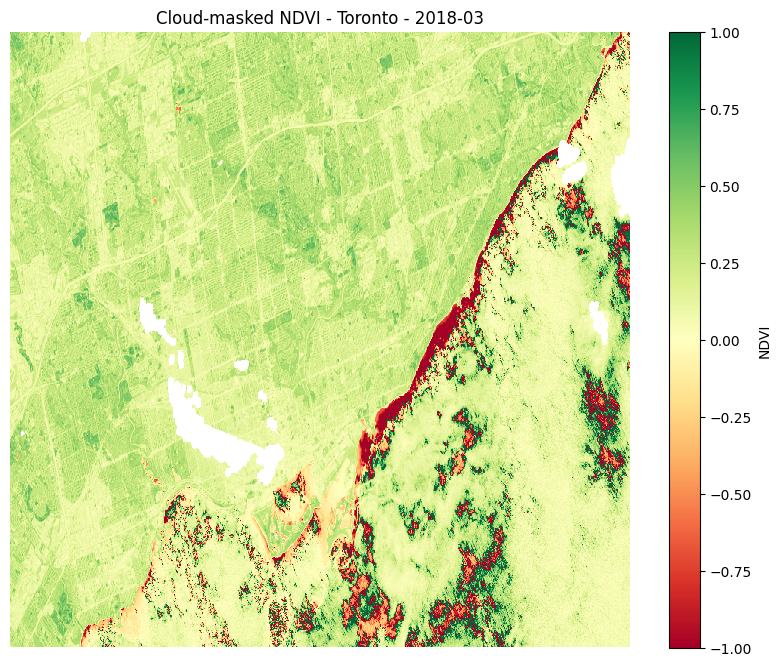

In [130]:
import numpy as np
import pystac_client
import stackstac
import xarray as xr
import matplotlib.pyplot as plt
from planetary_computer import sign

# Define parameters
bbox4326 = [-79.6, 43.58, -79.1, 43.8]
month = "2018-07"

# Get and sign items
catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
search = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=bbox4326,
    datetime=f"{month}-01/{month}-30",
    query={"eo:cloud_cover": {"lt": 50}},
)
items = [sign(it) for it in search.items() if it.id.startswith("LC08")]

# Create stack
stack = stackstac.stack(
    items,
    assets=["red", "nir08", "qa_pixel"],
    epsg=4326,
    resolution=0.00027,
    bounds_latlon=bbox4326,
    snap_bounds=True,
    rescale=True,
    fill_value=np.nan,
)

# Cloud masking
def mask_clear(qa):
    bad_bits = sum(1 << bit for bit in [0, 1, 2, 3, 4, 5])
    return (qa & bad_bits) == 0

qa_band = stack.sel(band="qa_pixel").astype("uint16")
clear_mask = mask_clear(qa_band)
stack_clean = stack.where(clear_mask).drop_sel(band="qa_pixel")

# 4) Compute NDVI
red_med = stack_clean.sel(band="red").median("time", skipna=True)
nir_med = stack_clean.sel(band="nir08").median("time", skipna=True)
ndvi = (nir_med - red_med) / (nir_med + red_med)
ndvi = ndvi.where(~np.isclose(nir_med + red_med, 0))

# Clip NDVI to valid range
ndvi = ndvi.clip(-1, 1)

# 5) Plot with installed bottleneck
vmin, vmax = ndvi.quantile([0.02, 0.98]).compute()

plt.figure(figsize=(10, 8))
ndvi.plot.imshow(
    cmap="RdYlGn",
    vmin=-1,
    vmax=1,
    add_colorbar=True,
    cbar_kwargs={"label": "NDVI"}
)
plt.title(f"Cloud-masked NDVI - Toronto - {month}")
plt.axis("off")
plt.show()

In [ ]:
import calendar
import numpy as np
import pandas as pd
import geopandas as gpd

import pystac_client, stackstac, xarray as xr, rioxarray
from planetary_computer import sign
from shapely.geometry import mapping
from rioxarray.exceptions import NoDataInBounds

import dask
from dask import delayed
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
from rasterio.errors     import RasterioIOError

#  Global, read-once resources
catalog  = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
bbox     = [-79.6, 43.58, -79.1, 43.8]           # AOI bounding box

#  Core work for a single month  (wrapped in dask.delayed later)
def process_month(month: str) -> pd.DataFrame:
    """Fetch Landsat-8 scenes for `month`, compute median NDVI, zonal-mean it."""
    year, mon = month.split("-")
    last_day  = calendar.monthrange(int(year), int(mon))[1]
    interval  = f"{month}-01/{month}-{last_day}"

    search = catalog.search(
        collections=["landsat-c2-l2"],
        bbox=bbox,
        datetime=interval,
        query={"eo:cloud_cover": {"lt": 50}},
    )
    items  = [sign(it) for it in search.items() if it.id.startswith("LC08")]

    if not items:
        return pd.DataFrame(
            {"hex_id": gdf_hex.hex_id.values,
             "month" : month,
             "NDVI"  : np.nan}
        )

    try:
        stack = stackstac.stack(
            items,
            assets        = ["red", "nir08", "qa_pixel"],
            epsg          = 4326,
            resolution    = 0.00027,
            bounds_latlon = bbox,
            snap_bounds   = True,
            rescale       = True,
            fill_value    = np.nan,
            chunks        = {"time": 1, "x": 1024, "y": 1024},
        )
    except TypeError:
        stack = stackstac.stack(
            items,
            assets        = ["red", "nir08", "qa_pixel"],
            epsg          = 4326,
            resolution    = 0.00027,
            bounds_latlon = bbox,
            snap_bounds   = True,
            rescale       = True,
            fill_value    = np.nan,
            chunksize     = 1024,
        ).chunk({"time": 1})

    # 3. Cloud mask + NDVI
    qa       = stack.sel(band="qa_pixel").astype("uint16")
    bad_bits = sum(1 << b for b in [0, 1, 2, 3, 4, 5])
    mask     = (qa & bad_bits) == 0

    red_med = (
        stack.sel(band="red")
            .where(mask)
            .median("time", skipna=True)
    )

    nir_med = (
        stack.sel(band="nir08")
            .where(mask)
            .median("time", skipna=True)
    )
    ndvi     = (
        (nir_med - red_med) / (nir_med + red_med)
    ).where(~np.isclose(nir_med + red_med, 0)).clip(-1, 1).rio.write_crs(4326)

    # Zonal statistics
    out = []
    for hid, geom in zip(gdf_hex.hex_id, gdf_hex.geometry):
        try:
            val = (
                ndvi.rio.clip([mapping(geom)], crs="EPSG:4326")
                    .mean(dim=("x", "y"), skipna=True)
                    .compute()
                    .item()
            )
        except (NoDataInBounds, RasterioIOError, RuntimeError):
            val = np.nan
        out.append({"hex_id": hid, "month": month, "NDVI": val})

    return pd.DataFrame(out)

#  Driver
def main():
    # Build list of delayed month tasks
    months = pd.period_range("2014-01", "2024-12", freq="M").strftime("%Y-%m")
    delayed_dfs = [delayed(process_month)(m) for m in months]

    # Create a Dask DataFrame from the delayed pieces
    meta = pd.DataFrame(
        {"hex_id": pd.Series(dtype=gdf_hex.hex_id.dtype),
         "month" : pd.Series(dtype="object"),
         "NDVI"  : pd.Series(dtype="float64")}
    )
    ddf = dd.from_delayed(delayed_dfs, meta=meta)

    # Materialise the full result
    df_ndvi_monthly = ddf.compute()
    print(df_ndvi_monthly.head())

    df_ndvi_monthly.to_parquet(
    "s3://paul-project-bucket/features/ndvi_monthly_filled",
    index=False,
    partition_cols=["month"]
    )

if __name__ == "__main__":
    main()

### 6. Raster Zonal Statistics: LST Processing
- Mirrors the NDVI workflow but targets the thermal (trad) band to compute LST.
- Applies a post-hoc calibration formula to the raw LST values before writing.

In [ ]:
# speed_ndvi.py  ── run with:  python -m dask.distributed.cli.dask  ./speed_ndvi.py
#
# or interactively:
# >>> from speed_ndvi import main
# >>> main(n_workers=6)

import calendar
import numpy as np
import pandas as pd
import geopandas as gpd

import pystac_client, stackstac, xarray as xr, rioxarray
from planetary_computer import sign
from shapely.geometry import mapping
from rioxarray.exceptions import NoDataInBounds

import dask
from dask import delayed
from dask.distributed import Client, LocalCluster
import dask.dataframe as dd
from rasterio.errors     import RasterioIOError

ASSETS_LST = ["trad", "qa_pixel"]
#  Global, read-once resources
catalog  = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
bbox     = [-79.6, 43.58, -79.1, 43.8]

def process_month_lst(month: str) -> pd.DataFrame:
    year, mon = month.split("-")
    last_day  = calendar.monthrange(int(year), int(mon))[1]
    interval  = f"{month}-01/{month}-{last_day}"

    # STAC search
    search = catalog.search(
        collections=["landsat-c2-l2"],
        bbox=bbox,
        datetime=interval,
        query={"eo:cloud_cover": {"lt": 50}},
    )

    items = [sign(it) for it in search.items() if it.id.startswith("LC08")]
    
    if not items:
        return pd.DataFrame(
            {"hex_id": gdf_hex.hex_id.values, "month": month, "LST_C": np.nan}
        )

    # Dask-backed stack
    try:
        stack = stackstac.stack(
            items, assets=ASSETS_LST,
            epsg=4326, resolution=0.00027,
            bounds_latlon=bbox, snap_bounds=True,
            rescale=True,  
            chunks        = {"time": 1, "x": 1024, "y": 1024},
        )
    except TypeError:    
        stack = stackstac.stack(
            items, assets=ASSETS_LST,
            epsg=4326, resolution=0.00027,
            bounds_latlon=bbox, snap_bounds=True,
            rescale=True,     
            fill_value=np.nan,
            chunksize     = 1024,
        ).chunk({"time": 1})
    
    # Cloud mask
    qa       = stack.sel(band="qa_pixel").astype("uint16")
    bad_bits = sum(1 << b for b in [0, 1, 2, 3, 4, 5])
    mask     = (qa & bad_bits) == 0

    # Median + scale to °C
    st_med      = stack.sel(band="trad").where(mask).median("time", skipna=True)
    lst_celsius = st_med + 149.0 - 273.15
    lst_celsius = (st_med).rio.write_crs(4326)

    # Zonal stats
    out = []
    for hid, geom in zip(gdf_hex.hex_id, gdf_hex.geometry):
        try:
            val = (
                lst_celsius.rio.clip([mapping(geom)], crs="EPSG:4326")
                           .mean(dim=("x", "y"), skipna=True)
                           .compute()
                           .item()
            )
        except (NoDataInBounds, RasterioIOError, RuntimeError):
            val = np.nan
        out.append({"hex_id": hid, "month": month, "LST_C": val})
    return pd.DataFrame(out)

#  Driver
def main():
    # Build list of delayed month tasks
    months = pd.period_range("2014-01", "2024-12", freq="M").strftime("%Y-%m")
    delayed_dfs = [delayed(process_month_lst)(m) for m in months]

    # Create a Dask DataFrame from the delayed pieces
    meta = pd.DataFrame(
    {"hex_id": pd.Series(dtype=gdf_hex.hex_id.dtype),
     "month" : pd.Series(dtype="object"),
     "LST_C" : pd.Series(dtype="float64")}
    )

    ddf = dd.from_delayed(delayed_dfs, meta=meta)

    # Materialise the full result
    df_lst_monthly = ddf.compute()      # ← ONE barrier, all workers hum in parallel
    print(df_lst_monthly.head())
    
    # optionally write to parquet / csv
    df_lst_monthly.to_parquet(
    "s3://paul-project-bucket/features/lst_monthly_filled",
    index=False,
    partition_cols=["month"]
    )

# convenient CLI entry-point
if __name__ == "__main__":
    main()

### 7.1 School Density
- Loads school locations, joins them to hexagons in-memory, and counts schools per hex.

In [18]:
import dask.dataframe as dd
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
import s3fs

s3 = s3fs.S3FileSystem(anon=False)
raw_path = "s3://paul-project-bucket/features/schools.csv"
s3.put(
    "School locations-all types data.csv",
    raw_path
)

# Read schools CSV from S3 with Dask, then bring into pandas
ddf_sch = dd.read_csv(
    "s3://paul-project-bucket/features/schools.csv",
    storage_options={"anon": False},
    assume_missing=True,
    dtype={"ADDRESS_NUMBER": "object", "LO_NUM_SUF": "object"}
)
pdf_sch = ddf_sch.compute()

# Build a GeoDataFrame of school points
gdf_sch = gpd.GeoDataFrame(
    pdf_sch,
    geometry=[Point(x, y) for x, y in zip(pdf_sch.LONGITUDE, pdf_sch.LATITUDE)],
    crs="EPSG:4326"
)

# Read hex‐grid Parquet from S3, then into pandas
ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()

# If hex Parquet has a WKT column, turn it into real geometries
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(wkt.loads)
gdf_hex = gpd.GeoDataFrame(pdf_hex, geometry="geometry", crs="EPSG:4326")

# Spatial‐join schools → hexes and count
joined = gpd.sjoin(
    gdf_sch,
    gdf_hex[["hex_id", "geometry"]],
    how="left",
    predicate="within"
)
school_counts = (
    joined
      .groupby("hex_id")
      .size()
      .reset_index(name="school_count")
)

# Write the resulting DataFrame back to S3 as Parquet
fs = s3fs.S3FileSystem(anon=False)
with fs.open("s3://paul-project-bucket/features/school_counts_by_hex.parquet", "wb") as f:
    school_counts.to_parquet(f, index=False)

print(f"Wrote {len(school_counts)} hex rows with school counts to S3")

Wrote 45 hex rows with school counts to S3


### 7.2 Pedestrian Traffic (TMC)
By aggregating daily pedestrian counts per hexagon, we obtain a dynamic, fine‐grained measure of human presence that—under reasonable assumptions about local mobility—serves as a proxy for population density. This approach is justified by:

- **Spatial Granularity**  
  Pedestrian counts are recorded at individual intersections or segments and then joined to 5 km hexes, capturing variations in density within neighborhoods that coarse census tracts would smooth over.

- **Temporal Resolution**  
  Unlike decennial census data, TMC counts are available at daily (or even hourly) resolution, allowing us to observe seasonal fluctuations (e.g. school terms, tourism peaks) and weekday/weekend patterns in “population” distribution.

- **Dynamic Population vs. Resident Population**  
  Footfall reflects not only residents but also commuters, shoppers, and visitors—capturing the **daytime population** that static surveys miss. This is critical when modeling phenomena (e.g. crime, service demand) driven by where people actually are at different times.

- **Low Latency & Cost-Effectiveness**  
  Traffic sensors continuously stream data; processing with Dask and S3 incurs minimal marginal cost compared to field surveys or licensing proprietary mobility datasets.

- **Validation in the Literature**  
  Numerous urban studies demonstrate strong correlations between pedestrian flow counts and ground‐truth population estimates (e.g. mobile-phone‐based density maps, survey panels), lending empirical support to this proxy.

By integrating pedestrian traffic into our hex–month feature matrix, we therefore enrich our model with a **near real-time, high-resolution indicator of human presence**, which—when combined with static land-use or school‐density layers—yields a more complete picture of urban population distribution.  

In [44]:
import dask.dataframe as dd
# Read without parse_dates (and allow missing values in numeric columns)
df = dd.read_csv(
    "tmc_raw_data_2010_2019.csv",
    assume_missing=True
)

# Convert to datetime explicitly
df["count_date"] = dd.to_datetime(
    df["count_date"],
    infer_datetime_format=True,
    errors="raise"
)

In [ ]:
import dask.dataframe as dd

# Read CSV without parse_dates (to avoid header-peeking errors)
df = dd.read_csv(
    "tmc_raw_data_2010_2019.csv",
    assume_missing=True
)

# Convert count_date to datetime
df["count_date"] = dd.to_datetime(
    df["count_date"],
    infer_datetime_format=True,
    errors="raise"
)

# Filter for 2014–2019 and select coords, date, and ped counts
df_filtered = df.loc[
    (df.count_date >= "2014-01-01") &
    (df.count_date <= "2019-12-31"),
    [
        "count_date",
        "longitude",
        "latitude",
        "n_appr_peds",
        "s_appr_peds",
        "e_appr_peds",
        "w_appr_peds",
    ]
]

# Drop any rows with missing ped-counts
df_filtered = df_filtered.dropna()

# Add total_peds
df_filtered = df_filtered.assign(
    total_peds=(
        df_filtered.n_appr_peds
      + df_filtered.s_appr_peds
      + df_filtered.e_appr_peds
      + df_filtered.w_appr_peds
    )
)

# Drop the original directional columns
df_filtered = df_filtered.drop(
    columns=[
        "n_appr_peds",
        "s_appr_peds",
        "e_appr_peds",
        "w_appr_peds",
    ]
)

# Inspect
print(df_filtered.head())

# write out to parquet
df_filtered.to_parquet(
    "s3://paul-project-bucket/features/tmc_filtered.parquet",
    engine="pyarrow",
    write_index=False,
    storage_options={"anon": False},
    compression="snappy"
)

In [15]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import shapely.wkt

ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(shapely.wkt.loads)
gdf_hex = gpd.GeoDataFrame(
    pdf_hex[["hex_id", "geometry"]],
    geometry="geometry",
    crs="EPSG:4326"
)

# Read traffic CSV into Dask, parse dates
ddf_peds = dd.read_parquet(
    "s3://paul-project-bucket/features/tmc_filtered.parquet",
    parse_dates=["count_date"],
    storage_options={"anon": False},
    dtype={"longitude": float, "latitude": float, "total_peds": float}
)

# Turn each row into a Point geometry
pdf_peds = ddf_peds.compute()
pdf_peds["geometry"] = pdf_peds.apply(
    lambda r: Point(r.longitude, r.latitude),
    axis=1
)
gdf_peds = gpd.GeoDataFrame(pdf_peds, geometry="geometry", crs="EPSG:4326")

# Spatially join points to hexagons
gdf_joined = gpd.sjoin(
    gdf_peds,
    gdf_hex,
    how="inner",
    predicate="within"
)[["count_date", "hex_id", "total_peds"]]

# Aggregate: for each day & hex, sum up total_peds
df_daily_hex = (
    gdf_joined
      .groupby([gdf_joined.count_date.dt.date, "hex_id"])
      .total_peds
      .sum()
      .reset_index()
      .rename(columns={"count_date": "date", "total_peds": "ped_count"})
)

print(df_daily_hex.head())

         date  hex_id  ped_count
0  2014-01-09      32     1530.0
1  2014-01-09      44      542.0
2  2014-01-13      51     2313.0
3  2014-01-14      32      123.0
4  2014-01-16      29      959.0


In [ ]:
import dask.dataframe as dd

df_2024 = dd.read_csv(
    "tmc_raw_data_2020_2029.csv",
    assume_missing=True
)

df_2024["count_date"] = dd.to_datetime(
    df_2024["count_date"],
    infer_datetime_format=True,
    errors="raise"
)

df_filtered = df_2024.loc[
    (df_2024.count_date >= "2020-01-01") &
    (df_2024.count_date <= "2024-12-31"),
    [
        "count_date",
        "longitude",
        "latitude",
        "n_appr_peds",
        "s_appr_peds",
        "e_appr_peds",
        "w_appr_peds",
    ]
]

df_filtered = df_filtered.dropna()

# Add total_peds
df_filtered = df_filtered.assign(
    total_peds=(
        df_filtered.n_appr_peds
      + df_filtered.s_appr_peds
      + df_filtered.e_appr_peds
      + df_filtered.w_appr_peds
    )
)

# Drop the original directional columns
df_filtered = df_filtered.drop(
    columns=[
        "n_appr_peds",
        "s_appr_peds",
        "e_appr_peds",
        "w_appr_peds",
    ]
)

# write out to parquet
df_filtered.to_parquet(
    "s3://paul-project-bucket/features/tmc_filtered_2024.parquet",
    engine="pyarrow",
    write_index=False,
    storage_options={"anon": False},
    compression="snappy"
)

In [16]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import shapely.wkt

ddf_hex = dd.read_parquet(
    "s3://paul-project-bucket/grid/hex5000.parquet",
    storage_options={"anon": False},
    engine="pyarrow"
)
pdf_hex = ddf_hex.compute()
pdf_hex["geometry"] = pdf_hex.geometry_wkt.map(shapely.wkt.loads)
gdf_hex = gpd.GeoDataFrame(
    pdf_hex[["hex_id", "geometry"]],
    geometry="geometry",
    crs="EPSG:4326"
)

ddf_peds = dd.read_parquet(
    "s3://paul-project-bucket/features/tmc_filtered_2024.parquet",
    parse_dates=["count_date"],
    storage_options={"anon": False},
    dtype={"longitude": float, "latitude": float, "total_peds": float}
)

pdf_peds = ddf_peds.compute()
pdf_peds["geometry"] = pdf_peds.apply(
    lambda r: Point(r.longitude, r.latitude),
    axis=1
)
gdf_peds = gpd.GeoDataFrame(pdf_peds, geometry="geometry", crs="EPSG:4326")

gdf_joined = gpd.sjoin(
    gdf_peds,
    gdf_hex,
    how="inner",
    predicate="within"
)[["count_date", "hex_id", "total_peds"]]

df_daily_hex_2024 = (
    gdf_joined
      .groupby([gdf_joined.count_date.dt.date, "hex_id"])
      .total_peds
      .sum()
      .reset_index()
      .rename(columns={"count_date": "date", "total_peds": "ped_count"})
)

print(df_daily_hex_2024.head())

         date  hex_id  ped_count
0  2020-01-08      30     3040.0
1  2020-01-14      28       29.0
2  2020-01-15      27      450.0
3  2020-01-15      28     1492.0
4  2020-01-15      29     2235.0


In [19]:
import dask.dataframe as dd

df_all = dd.concat([df_daily_hex, df_daily_hex_2024], axis=0)

df_all["month"] = dd.to_datetime(df_all["date"]).dt.to_period("M")

# partition on that Period column
df_all.to_parquet(
    "s3://paul-project-bucket/features/daily_hex_all",
    engine="pyarrow",
    write_index=False,
    partition_on=["month"],
    storage_options={"anon": False},
    compression="snappy"
)

In [20]:
test = dd.read_parquet(
    "s3://paul-project-bucket/features/daily_hex_all",
    storage_options={"anon": False}
)
print(test.head())

         date  hex_id  ped_count    month
0  2014-01-09      32     1530.0  2014-01
1  2014-01-09      44      542.0  2014-01
2  2014-01-13      51     2313.0  2014-01
3  2014-01-14      32      123.0  2014-01
4  2014-01-16      29      959.0  2014-01


In [21]:
import dask.dataframe as dd
from dask import dataframe as dd_frame
ddf = dd.read_parquet("s3://paul-project-bucket/features/daily_hex_all", storage_options={"anon": False})

# 2) (If month isn’t already a string “YYYY-MM”, create it)
ddf["date"] = dd.to_datetime(ddf["date"])
ddf["month"] = ddf["date"].dt.strftime("%Y-%m")

# 3) Group by hex_id & month and sum ped_count
ddf_monthly = (
    ddf
    .groupby(["hex_id", "month"])["ped_count"]
    .sum()
    .reset_index()
    .rename(columns={"ped_count": "monthly_ped_count"})
)

# 4) (Optional) Reorder columns
ddf_monthly = ddf_monthly[["hex_id", "month", "monthly_ped_count"]]

# 5) Inspect
print(ddf_monthly.head())

# 6) Write out to parquet
ddf_monthly.to_parquet(
    "s3://paul-project-bucket/features/monthly_hex_all",
    engine="pyarrow",
    write_index=False,
    partition_on=["month"],
    storage_options={"anon": False},
    compression="snappy"
)

   hex_id    month  monthly_ped_count
0    29.0  2014-03              962.0
1    37.0  2014-04             5694.0
2    65.0  2014-04              166.0
3    27.0  2014-05              475.0
4    58.0  2014-05              211.0


In [19]:
import dask.dataframe as dd

# 1) Read your daily‐crime table (assuming Parquet; if CSV, use dd.read_csv)
ddf_crime = dd.read_parquet("s3://paul-project-bucket/features/crime_daily", storage_options={"anon": False}
                            , engine="pyarrow")

# 2) If hex_id and day are the index, bring them back as columns
ddf_crime = ddf_crime.reset_index()  # now you have columns ['hex_id', 'day', 'crime_n']

# 3) Make sure `day` is datetime, then extract “YYYY-MM” for month
ddf_crime["day"]   = dd.to_datetime(ddf_crime["day"])
ddf_crime["month"] = ddf_crime["day"].dt.strftime("%Y-%m")

# 4) Group by hex_id & month and sum up crime_n
ddf_crime_monthly = (
    ddf_crime
    .groupby(["hex_id", "month"])["crime_n"]
    .sum()
    .reset_index()
    .rename(columns={"crime_n": "total_crime"})
)

# 5) (Optional) reorder columns
ddf_crime_monthly = ddf_crime_monthly[["hex_id", "month", "total_crime"]]

# 6) (Optional) persist back to S3
ddf_crime_monthly.to_parquet(
    "s3://paul-project-bucket/features/crime_monthly_totals",
    write_index=False
)

2025-05-24 18:37:29,222 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 163a1dd674e866d57aac10279001ebd2 initialized by task ('shuffle-transfer-163a1dd674e866d57aac10279001ebd2', 9) executed on worker tcp://127.0.0.1:62763
2025-05-24 18:37:29,700 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 163a1dd674e866d57aac10279001ebd2 deactivated due to stimulus 'task-finished-1748129849.7003'


In [23]:
client.close()
cluster.close()

Terminated dask-bbc9b753-worker-0113496f (i-0248da15334cb9603)
Terminated dask-bbc9b753-worker-8b403695 (i-07396cf1e94456619)
Terminated dask-bbc9b753-worker-d02c0aa7 (i-0314b538645ea4ac9)
Terminated dask-bbc9b753-worker-465b244e (i-0d97f4cbb2815f4d8)
Terminated dask-bbc9b753-scheduler (i-061d514aa3597bce9)
